# Libraries

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from qwikidata.linked_data_interface import get_entity_dict_from_api
from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
import pandas as pd
import pickle
import tensorflow as tf
import nltk
from nltk import sent_tokenize
import nltk.corpus
import re
import bs4,requests, webbrowser
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
import urllib.request
import random
import PyPDF2
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss, f1_score
from sklearn.metrics import classification_report,confusion_matrix
from pandas import Series, DataFrame 
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf
from sklearn.metrics import roc_auc_score


# Constants

In [44]:
myprint = True
BOB = 1
bob_link = "https://www.wikidata.org/wiki/Q25310"
PATHBOB = r"C:\\Users\\kikis\\Desktop\\TESIII\\Script\\PDF\\bob"

JOHN = 0
john_link = "https://www.wikidata.org/wiki/Q9696"
PATH = os.getcwd()
PATHJOHN = r"C:\\Users\\kikis\\Desktop\\TESIII\\Script\\PDF\\john"
links = [bob_link, john_link]
persons = [BOB, JOHN]

# Print function

In [45]:
def myprint(toprint):
    if myprint:
        print(toprint)      

# Returns nickname list

In [46]:
def get_nicknames(link):
    response = requests.get(link)
    response.raise_for_status()
    soup = bs4.BeautifulSoup(response.text, 'html.parser')
    nicknames = soup.find_all('li', class_='wikibase-entitytermsview-aliases-alias')
    list = []
    for nickname in nicknames:
        if nickname:
            list.append(nickname.find_next(text=True).strip())
    return list

In [47]:
getnicknames_bob  = get_nicknames(bob_link)

In [48]:
getnicknames_john  = get_nicknames(john_link)

In [49]:
myprint(getnicknames_bob)
myprint(getnicknames_john)

['Bobby Kennedy', 'RFK', 'Robert Kennedy', 'Robert Francis Kennedy']
['Kennedy', 'Jack Kennedy', 'President Kennedy', 'John Fitzgerald Kennedy', 'J. F. Kennedy', 'JFK', 'John Kennedy', 'John Fitzgerald "Jack" Kennedy', 'JF Kennedy']


In [50]:
getnicknames_bob.append("Robert F. Kennedy")
getnicknames_john.remove("Kennedy")
getnicknames_john.append("John F. Kennedy")
myprint(getnicknames_bob)
myprint(getnicknames_john)
total_nicknames = getnicknames_john + getnicknames_bob 


['Bobby Kennedy', 'RFK', 'Robert Kennedy', 'Robert Francis Kennedy', 'Robert F. Kennedy']
['Jack Kennedy', 'President Kennedy', 'John Fitzgerald Kennedy', 'J. F. Kennedy', 'JFK', 'John Kennedy', 'John Fitzgerald "Jack" Kennedy', 'JF Kennedy', 'John F. Kennedy']


# Read sentences

In [51]:
def read_pdfs(dirPath):
    result = [f for f in os.listdir(dirPath) if (os.path.isfile(os.path.join(dirPath, f)) and f.endswith(".pdf"))]
    total_sentences = []
    for file in result:
        final_path = os.path.join(dirPath, file)
        pdf_file = open(final_path, 'rb')
        read_pdf = PyPDF2.PdfFileReader(pdf_file)
        total_pages = read_pdf.numPages
        for pag in range (0, total_pages):
    #Creating a page object
            pageObj = read_pdf.getPage(pag)
    #Extracting text from page
            sentences = sent_tokenize(pageObj.extractText())
            total_sentences = total_sentences + sentences
    #Closing the pdf file object
        pdf_file.close()
    return total_sentences

In [52]:
total_sentences = read_pdfs(PATH)
print("There are", len(total_sentences), "sentences.")
#print("An example of extraction:","\n", total_sentences[7])

There are 3726 sentences.


In [53]:
relevant_sentences = []
rem_common_nick = True
def getrelevantsentences(list_nick_firstID, list_nick_secondID, total_sentences, relevant_sentences,rem_common_nick):
    related_nicknames = []
    ids = []
    for sent in read_pdfs(PATH):
        for nick in list_nick_firstID:
            times = sent.find(nick)
            if (times >= 0):
                relevant_sentences.append(sent)
                related_nicknames.append(nick)
                ids.append(BOB)   
        for nickj in list_nick_secondID: #check over all the nicknames of John
            times = sent.find(nickj)
            if (times >= 0):
                relevant_sentences.append(sent)
                related_nicknames.append(nickj)
                ids.append(JOHN)
    #Remove common nicknames
    if rem_common_nick:
        for sent in relevant_sentences:
            for nick in list_nick_firstID: #check over all the nicknames of Bob
                times = sent.find(nick) #nick of R in john's sentences
                if (times >= 0):
                    for nickj in list_nick_secondID:
                        times_j = sent.find(nickj) #nick of R in john's sentences
                        if (times_j >= 0):
                            sent = sent.replace(nickj, "")
            for nick in list_nick_secondID: #check over all the nicknames of John
                times = sent.find(nick) 
                if (times >= 0):
                    for nickb in list_nick_firstID:
                        times_b = sent.find(nickb) 
                        if (times_b >= 0):
                            sent = sent.replace(nickb, "")
    silv_dataset = {'Sentence': relevant_sentences , 'Nickname used': related_nicknames, 'ID': ids } 
    df = pd.DataFrame(data=silv_dataset)
    return df

# Generate sentences and keep only those with nicknames and put 0 for John and 1 for Rob. 
I will save sentences without nicknames in a separate df


In [54]:
df = getrelevantsentences(getnicknames_bob, getnicknames_john, total_sentences, relevant_sentences, rem_common_nick)

In [55]:
myprint(df.head())
df.shape

                                            Sentence      Nickname used  ID
0  4 The role the Joint Chiefs of Staff (JCS) pla...  President Kennedy   0
1   92 N AV AL W AR COLLEGE REVIEW\nForce operati...  President Kennedy   0
2   94 N AV AL W AR COLLEGE REVIEW\noffensive wea...  President Kennedy   0
3   96 N AV AL W AR COLLEGE REVIEW\nThis desire b...  President Kennedy   0
4  ”42\nCNO Anderson and CSA Wheeler both agreed ...  President Kennedy   0


(263, 3)

In [56]:
def preprocess_text(text: str, remove_stopwords: bool):
    text = re.sub(r"www\S+", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"�", "", text)
    text = re.sub(r"\x00","", text)
    return text

In [57]:
df["Sentence"] = df["Sentence"].apply(
    lambda x: preprocess_text(str(x), True)
)

In [58]:
saved_df = df.to_csv("Dataset.csv", index=False)

In [59]:
df = pd.read_csv("Dataset.csv")
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset.")



There are 263 rows and 3 columns in the dataset.


In [60]:
def replace_nickname(sentence):
    for nick in total_nicknames:
        sentence = sentence.replace(nick, "")
    return sentence

In [61]:
df["Sentence_no_nicknames"] = df["Sentence"].apply(
    lambda x: replace_nickname(x), True)


In [62]:
np.random.seed(55) 
df.sample(10) #Visualize only 10 rows.

,Sentence,Nickname used,ID,Sentence_no_nicknames
200,Yet Bobby Kennedy somehow beca me a liberal ic...,Bobby Kennedy,1,"Yet somehow beca me a liberal icon, an antiwa..."
185,Consistent with President Kennedy's Alliance ...,President Kennedy,0,"Consistent with 's Alliance for Progress , he..."
203,"Josh Zeitz of Politico observed, ""Bobby Kenn...",Bobby Kennedy,1,"Josh Zeitz of Politico observed, "" has \nsin..."
244,"As Attorney General, Robert Kennedy had \nin m...",Robert Kennedy,1,"As Attorney General, had \nin many ways serve..."
196,[310] \nBurial \nMain article: Grave of Robe...,Robert F. Kennedy,1,[310] \nBurial \nMain article: Grave of \n...
26,The two men had essentially been enemies \nsin...,Bobby Kennedy,1,The two men had essentially been enemies \nsin...
150,[99] RFK wanted his brother to choose labor le...,RFK,1,[99] wanted his brother to choose labor leade...
143,[84] Kennedy was also a delegate at the 1956 ...,JFK,0,[84] Kennedy was also a delegate at the 1956 ...
240,"In September of 1962, Robert Kennedy sent U.S.",Robert Kennedy,1,"In September of 1962, sent U.S."
87,"49 John Kennedy, “Annual Message to the Congre...",John Kennedy,0,"49 , “Annual Message to the Congress on the St..."


0    138
1    125
Name: ID, dtype: int64


<AxesSubplot:title={'center':'Count (target)'}>

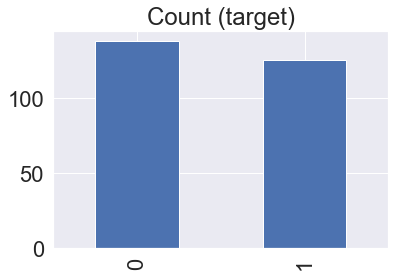

In [63]:
#Separate majority and minority classes
target_count = df['ID'].value_counts()
myprint(target_count)
df_majority = df[df['ID']== 0] #JFK
df_minority = df[df['ID']== 1] #RFK
target_count.plot(kind='bar', title='Count (target)')

# Functions

In [64]:
#Defining a function for Confusion matrix
sns.set(font_scale=2.0) # to set font size for the matrix
def view_confusion_matrix(y_actual,y_predict):

    cm = confusion_matrix(y_actual,y_predict)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]   #Flatten a matrix to one dimension.
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2,v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    #Choose label and colours
    sns.heatmap(cm, annot=labels, fmt='',cmap='Pastel1_r')
    plt.ylabel('Truth label')
    plt.xlabel('Predicted label')

In [65]:
def metrics(y_test, preds, predsprob ): 
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds,  zero_division=0))
    print("Recall:", recall_score(y_test, preds,  zero_division=0))
    print("Neg. Log-Likelihood:", log_loss(y_test, predsprob))

# Vectorizer 

In [66]:
vectorizer = TfidfVectorizer()

# Train test 30%


In [67]:
X_train, X_test, y_train, y_test = train_test_split(df.Sentence ,df.ID, test_size=0.30, random_state = 42)

In [68]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test).toarray()
#vectorizer.vocabulary_

# Build the logistic regressor and train it

In [69]:
model = LogisticRegression()
model

LogisticRegression()

In [70]:
model.fit(X_train_tfidf, y_train)

LogisticRegression()

# Prediction

Accuracy: 0.8354430379746836
Precision: 0.8181818181818182
Recall: 0.7941176470588235
Neg. Log-Likelihood: 0.5557601541193181
0.9510869565217391


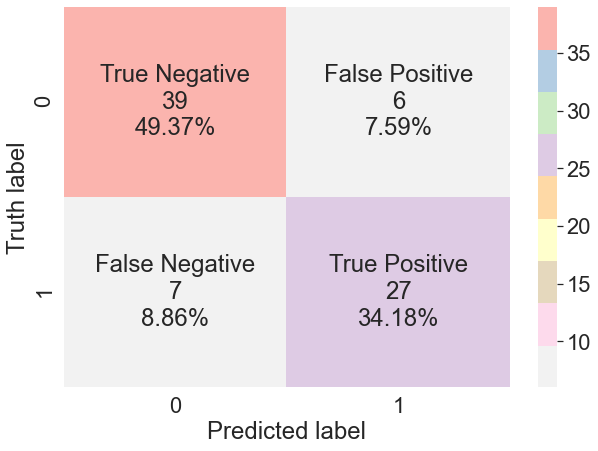

In [71]:
preds = model.predict(X_test_tfidf) 
preds_y = model.predict_proba(X_test_tfidf) 
metrics(y_test, preds, preds_y)
print(model.score(X_train_tfidf, y_train))
view_confusion_matrix(y_test, preds)

In [72]:
y_pred_train = model.predict(X_train_tfidf)
print("Accuracy on training set : ", accuracy_score(y_train,y_pred_train))
print("Accuracy on test set : ", accuracy_score(y_test, preds))

print("\nRecall on training set : ", recall_score(y_train,y_pred_train))
print("Recall on test set : ", recall_score(y_test,preds))
    
print("\nPrecision on training set : ",precision_score(y_train,y_pred_train, zero_division=0))
print("Precision on test set : ",precision_score(y_test,preds))
    
print("\nF1 on training set : ",f1_score(y_train,y_pred_train, zero_division=0))
print("F1 on test set : ",f1_score(y_test,preds))

Accuracy on training set :  0.9510869565217391
Accuracy on test set :  0.8354430379746836

Recall on training set :  0.9340659340659341
Recall on test set :  0.7941176470588235

Precision on training set :  0.9659090909090909
Precision on test set :  0.8181818181818182

F1 on training set :  0.9497206703910613
F1 on test set :  0.8059701492537314


# Obscure nicknames in the X_train

In [73]:
X_train_nonick, X_test_nonick, _ , _ = train_test_split(df.Sentence_no_nicknames ,df.ID, test_size=0.30, random_state = 42)

In [74]:
X_train_tfidf_nonick = vectorizer.transform(X_train_nonick)
X_test_tfidf_nonick = vectorizer.transform(X_test_nonick).toarray()

# Prediction with obscure nicknames (Log Reg)

Accuracy: 0.6582278481012658
Precision: 0.6129032258064516
Recall: 0.5588235294117647
Neg. Log-Likelihood: 0.6405763671086205
0.9565217391304348


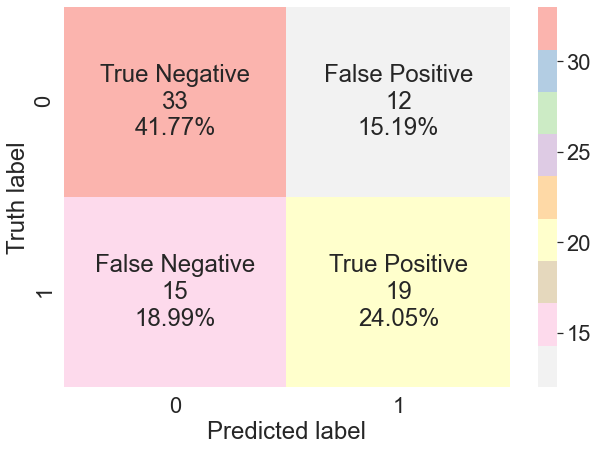

In [75]:
preds_nonick = model.predict(X_test_tfidf_nonick) 
preds_nonick_y = model.predict_proba(X_test_tfidf_nonick) 
metrics(y_test, preds_nonick, preds_nonick_y)
print(model.score(X_train_tfidf_nonick, y_train))
view_confusion_matrix(y_test,preds_nonick)

In [76]:
y_pred_train_nonick = model.predict(X_train_tfidf_nonick)
print("Accuracy on training set : ", accuracy_score(y_train,y_pred_train_nonick))
print("Accuracy on test set : ", accuracy_score(y_test, preds_nonick))

print("\nRecall on training set : ", recall_score(y_train,y_pred_train_nonick))
print("Recall on test set : ", recall_score(y_test,preds_nonick))
    
print("\nPrecision on training set : ",precision_score(y_train,y_pred_train_nonick, zero_division=0))
print("Precision on test set : ",precision_score(y_test,preds_nonick))
    
print("\nF1 on training set : ",f1_score(y_train,y_pred_train_nonick, zero_division=0))
print("F1 on test set : ",f1_score(y_test,preds_nonick))

Accuracy on training set :  0.9565217391304348
Accuracy on test set :  0.6582278481012658

Recall on training set :  0.9560439560439561
Recall on test set :  0.5588235294117647

Precision on training set :  0.9560439560439561
Precision on test set :  0.6129032258064516

F1 on training set :  0.9560439560439561
F1 on test set :  0.5846153846153845


#  Re-fitting to obscured dataset and re-testing

In [77]:
model.fit(X_train_tfidf_nonick, y_train)

LogisticRegression()

# Performance improves after fitting

In [78]:
#Accuracy: 0.6582278481012658
#Precision: 0.6129032258064516
#Recall: 0.5588235294117647
#Neg. Log-Likelihood: 0.6405763671086205
#0.9565217391304348

Accuracy: 0.6835443037974683
Precision: 0.6363636363636364
Recall: 0.6176470588235294
Neg. Log-Likelihood: 0.6333567111693035
0.9510869565217391


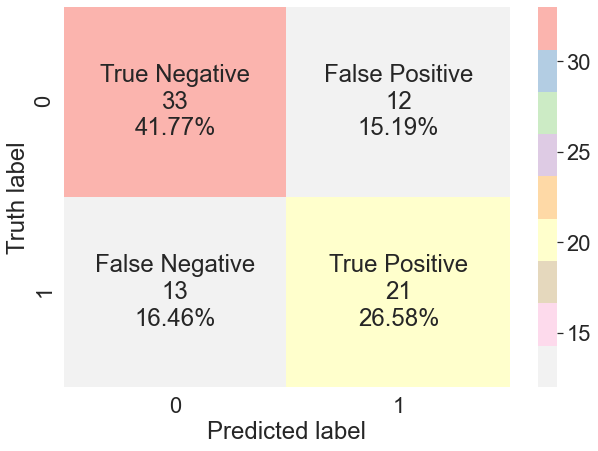

In [79]:
preds_nonick = model.predict(X_test_tfidf_nonick) 
preds_nonick_y = model.predict_proba(X_test_tfidf_nonick) 
metrics(y_test, preds_nonick, preds_nonick_y)
print(model.score(X_train_tfidf_nonick, y_train))
view_confusion_matrix(y_test, preds_nonick)

In [80]:
y_pred_train_nonick = model.predict(X_train_tfidf_nonick)
print("Accuracy on training set : ", accuracy_score(y_train,y_pred_train_nonick))
print("Accuracy on test set : ", accuracy_score(y_test, preds_nonick))

print("\nRecall on training set : ", recall_score(y_train,y_pred_train_nonick))
print("Recall on test set : ", recall_score(y_test,preds_nonick))
    
print("\nPrecision on training set : ",precision_score(y_train,y_pred_train_nonick, zero_division=0))
print("Precision on test set : ",precision_score(y_test,preds_nonick))
    
print("\nF1 on training set : ",f1_score(y_train,y_pred_train_nonick, zero_division=0))
print("F1 on test set : ",f1_score(y_test,preds_nonick))

Accuracy on training set :  0.9510869565217391
Accuracy on test set :  0.6835443037974683

Recall on training set :  0.9340659340659341
Recall on test set :  0.6176470588235294

Precision on training set :  0.9659090909090909
Precision on test set :  0.6363636363636364

F1 on training set :  0.9497206703910613
F1 on test set :  0.6268656716417911


In [85]:
0.6268656716417911 - 0.5846153846153845

0.04225028702640654

# Neural network

In [38]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50, 20,20, 20, 2), random_state=1)
nn.fit(X_train_tfidf, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(50, 20, 20, 20, 2),
              random_state=1, solver='lbfgs')

# Neural network predictions


In [39]:
#LOGISTIC REGRESSION
#Accuracy: 0.8354430379746836
#Precision: 0.8181818181818182
#Recall: 0.7941176470588235
#Neg. Log-Likelihood: 5.683656844536963
#0.9510869565217391

Accuracy: 0.7848101265822784
Precision: 0.7073170731707317
Recall: 0.8529411764705882
Neg. Log-Likelihood: 7.432516378261317
0.9619565217391305


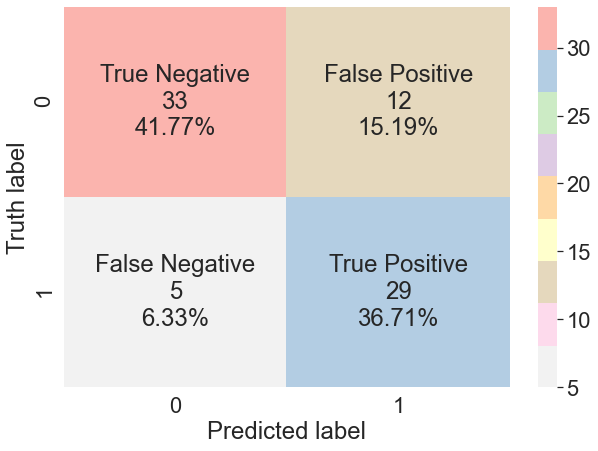

In [40]:
preds_nn = nn.predict(X_test_tfidf) 
metrics(y_test, preds_nn, preds_nn)
print(nn.score(X_train_tfidf, y_train))
view_confusion_matrix(y_test,preds_nn)

In [41]:
y_pred_train_nn = nn.predict(X_train_tfidf)
print("Accuracy on training set : ", accuracy_score(y_train,y_pred_train_nn))
print("Accuracy on test set : ", accuracy_score(y_test, preds_nn))

print("\nRecall on training set : ", recall_score(y_train,y_pred_train_nn))
print("Recall on test set : ", recall_score(y_test,preds_nn))
    
print("\nPrecision on training set : ",precision_score(y_train,y_pred_train_nn, zero_division=0))
print("Precision on test set : ",precision_score(y_test,preds_nn))
    
print("\nF1 on training set : ",f1_score(y_train,y_pred_train_nn, zero_division=0))
print("F1 on test set : ",f1_score(y_test,preds_nn))

Accuracy on training set :  0.9619565217391305
Accuracy on test set :  0.7848101265822784

Recall on training set :  0.978021978021978
Recall on test set :  0.8529411764705882

Precision on training set :  0.9468085106382979
Precision on test set :  0.7073170731707317

F1 on training set :  0.9621621621621622
F1 on test set :  0.7733333333333334


#  Obscure nicknames NN

Accuracy: 0.6582278481012658
Precision: 0.6060606060606061
Recall: 0.5882352941176471
Neg. Log-Likelihood: 11.804523511761783
0.9619565217391305


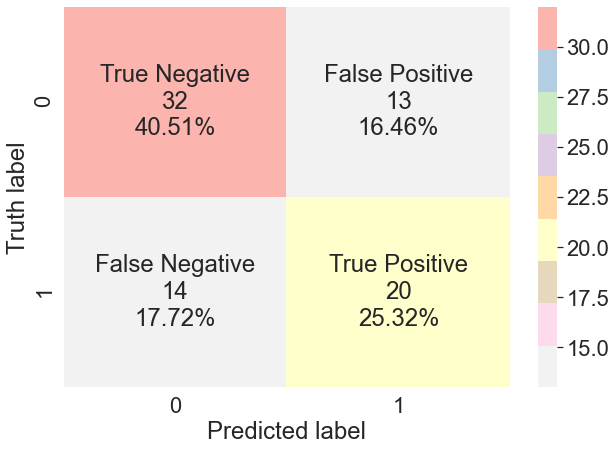

In [42]:
preds_nonick_nn = nn.predict(X_test_tfidf_nonick) 
metrics(y_test, preds_nonick_nn, preds_nonick_nn)
print(nn.score(X_train_tfidf_nonick, y_train))
view_confusion_matrix(y_test,preds_nonick_nn)

In [44]:
y_pred_train_nonick_nn = nn.predict(X_train_tfidf_nonick)
print("Accuracy on training set : ", accuracy_score(y_train,y_pred_train_nonick_nn))
print("Accuracy on test set : ", accuracy_score(y_test, preds_nonick_nn))

print("\nRecall on training set : ", recall_score(y_train,y_pred_train_nonick_nn))
print("Recall on test set : ", recall_score(y_test,preds_nonick_nn))
    
print("\nPrecision on training set : ",precision_score(y_train,y_pred_train_nonick_nn, zero_division=0))
print("Precision on test set : ",precision_score(y_test,preds_nonick_nn))
    
print("\nF1 on training set : ",f1_score(y_train,y_pred_train_nonick_nn, zero_division=0))
print("F1 on test set : ",f1_score(y_test,preds_nonick_nn))

Accuracy on training set :  0.9619565217391305
Accuracy on test set :  0.6582278481012658

Recall on training set :  0.978021978021978
Recall on test set :  0.5882352941176471

Precision on training set :  0.9468085106382979
Precision on test set :  0.6060606060606061

F1 on training set :  0.9621621621621622
F1 on test set :  0.5970149253731343


# Performance after fitting without nicknames NN

In [45]:
nn.fit(X_train_tfidf_nonick, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(50, 20, 20, 20, 2),
              random_state=1, solver='lbfgs')

Accuracy: 0.6835443037974683
Precision: 0.6216216216216216
Recall: 0.6764705882352942
Neg. Log-Likelihood: 10.93013423084544
0.9619565217391305


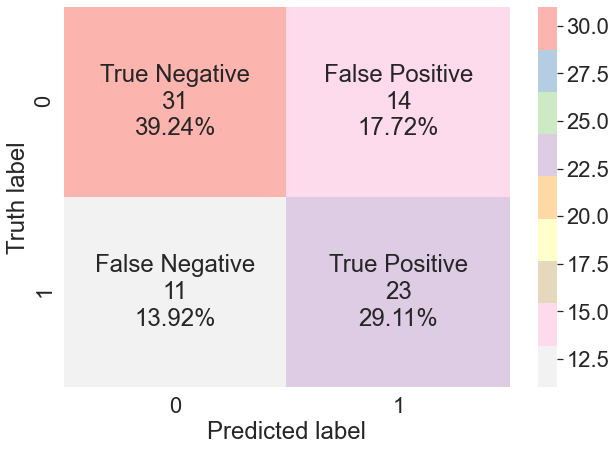

In [46]:
preds_nonick_nn = nn.predict(X_test_tfidf_nonick) 
metrics(y_test, preds_nonick_nn, preds_nonick_nn)
print(nn.score(X_train_tfidf_nonick, y_train))
view_confusion_matrix(y_test,preds_nonick_nn)

In [48]:
y_pred_train_nonick_nn = nn.predict(X_train_tfidf_nonick)
print("Accuracy on training set : ", accuracy_score(y_train,y_pred_train_nonick_nn))
print("Accuracy on test set : ", accuracy_score(y_test, preds_nonick_nn))

print("\nRecall on training set : ", recall_score(y_train,y_pred_train_nonick_nn))
print("Recall on test set : ", recall_score(y_test,preds_nonick_nn))
    
print("\nPrecision on training set : ",precision_score(y_train,y_pred_train_nonick_nn, zero_division=0))
print("Precision on test set : ",precision_score(y_test,preds_nonick_nn))
    
print("\nF1 on training set : ",f1_score(y_train,y_pred_train_nonick_nn, zero_division=0))
print("F1 on test set : ",f1_score(y_test,preds_nonick_nn))

Accuracy on training set :  0.9619565217391305
Accuracy on test set :  0.6835443037974683

Recall on training set :  0.978021978021978
Recall on test set :  0.6764705882352942

Precision on training set :  0.9468085106382979
Precision on test set :  0.6216216216216216

F1 on training set :  0.9621621621621622
F1 on test set :  0.6478873239436619


In [52]:
0.6478873239436619 - 0.5970149253731343

0.05087239857052761

#  Backup df

In [98]:
def backupsentences(total_sentences_firstID,total_sentences_secondID, relevant_sentences):
    backup = []
    for sent in total_sentences_firstID:
        if sent not in relevant_sentences:
            backup.append(sent)
    for sent in total_sentences_secondID:
        if sent not in relevant_sentences:
            backup.append(sent)
    backup_dataset = {'Sentence': backup} 
    backupdf = pd.DataFrame(data=backup_dataset)
    return backupdf

In [99]:
total_sentences_john = read_pdfs(PATHJOHN)
total_sentences_bob = read_pdfs(PATHBOB)
backupdf = backupsentences(total_sentences_john,total_sentences_bob, relevant_sentences)

backupdf["Sentence"] = backupdf["Sentence"].apply(
    lambda x: preprocess_text(str(x), True)
)


# Common nicknames


In [100]:
common_nick = "Kennedy"
common_sent = []
for ind in backupdf.index :
    if common_nick in backupdf["Sentence"][ind]:
        common_sent.append(backupdf["Sentence"][ind])

In [115]:
union_dataset = {'Sentence': common_sent} 
uniondf = pd.DataFrame(data=union_dataset)
np.random.seed(35) 
uniondf.sample(20)
#uniondf.head()   

,Sentence
772,[105] \nUpon hearing yet again the assertion t...
404,"Ross, seeing Kennedy so sick, did not look for..."
711,[248] To put \naside reports of a rift with Jo...
298,”\n96 Vietnam and other underdeveloped countri...
609,[citation needed ] Kennedy saw voting as the k...
634,[184] Tye views Kennedy following the death of...
269,”\n74 \nThe lack of specificity on Indochina d...
205,Kennedy inherited \nthis commitment and theref...
40,"His parents, Joseph and \nRose Kennedy were me..."
580,[108] [109] \nThe deputy and assistant attorne...


### I try my hand at prediction skills on some sentences containing the nickname Kennedy to see if it correctly classifies that it is John Kennedy or Bob Kennedy

In [126]:
myprint(uniondf["Sentence"][378])
X_sentence_tfidf = vectorizer.transform(pd.Series(uniondf["Sentence"][378])).toarray()
myprint(model.predict(X_sentence_tfidf))
print("Title:" , "Survival Long before he became President, J.F.K. battled to save himself and his men while adrift in the South Pacific")
myprint("Correctly classified")
myprint("\n")

myprint(uniondf["Sentence"][846])
X_sentence_tfidf1 = vectorizer.transform(pd.Series(uniondf["Sentence"][427])).toarray()
myprint(model.predict(X_sentence_tfidf1))
myprint("Not correctly classified")
myprint("\n")

myprint(uniondf["Sentence"][30])
X_sentence_tfidf2 = vectorizer.transform(pd.Series(uniondf["Sentence"][30])).toarray()
myprint(model.predict(X_sentence_tfidf2))
print("Title:" , "Assassination of Robert F. Kennedy")
myprint("Correctly classified")
myprint("\n")

myprint(uniondf["Sentence"][246])
X_sentence_tfidf3 = vectorizer.transform(pd.Series(uniondf["Sentence"][246])).toarray()
myprint(model.predict(X_sentence_tfidf3))
print("Title:" , "JFK AND VIETNAM: THE SEPTEMBER 1963 TV INTERVIEWS")
myprint("Correctly classified")
myprint("\n")

myprint(uniondf["Sentence"][800])
X_sentence_tfidf5 = vectorizer.transform(pd.Series(uniondf["Sentence"][427])).toarray()
myprint(model.predict(X_sentence_tfidf5))
print("Title:" , "Robert F. Kennedy")
myprint("Not correctly classified")

Mr. Kennedy!
[0]
Title: Survival Long before he became President, J.F.K. battled to save himself and his men while adrift in the South Pacific
Correctly classified


In 1957, my grandfather, Ambassador Joseph P. Kennedy, sat on a 
secret committee charged with investigating the CIA’s clandestine mischief in the Mideast.
[0]
Not correctly classified


Only two months later, and just after winning the Democratic presidential primary in 
California, Kennedy was fatally wounded at the Ambassador Hot el in Los Angeles, CA.
[1]
Title: Assassination of Robert F. Kennedy
Correctly classified


In this way, Kennedy’s images of gov-
ernment, the United States, and Vietnam coalesce and provide insight into 
the motivations behind the policies and agendas he pursues in Vietnam.
[0]
Title: JFK AND VIETNAM: THE SEPTEMBER 1963 TV INTERVIEWS
Correctly classified


[378] 
A bust of Kennedy resides in the library of the University of Virginia School of Law 
where he obtained his law degree.
[0]
Title: R

## Neural Networks Testing Random OverSampling (SMOTE): 
<a id="neural_networks"></a>
Simple Neural Network (with one hidden layer) in order to see  which of the two logistic regressions models it implemented in the (oversample(SMOTE)) has a better accuracy for detecting the character. <br><br>

In [15]:
relevant_sentences = []

df_non_mutual = getrelevantsentences( get_nicknames(bob_link), get_nicknames(john_link), total_sentences, relevant_sentences, rem_common_nick)

In [18]:
df_non_mutual["Sentence"] = df_non_mutual["Sentence"].apply(
    lambda x: preprocess_text(str(x), True)
)

In [19]:
np.random.seed(55)
print(f"There are {df_non_mutual.shape[0]} rows and {df_non_mutual.shape[1]} columns in the dataset.")

df_non_mutual.sample(10) #Visualize only 10 rows.

There are 1248 rows and 3 columns in the dataset.


,Sentence,Nickname used,ID
587,"RFK and Tragedy \nOn November 20, 1963, Rober...",RFK,1
1063,Robert and Ethel Kennedy later had eleven chil...,Kennedy,0
389,"17 For Kennedy, the battlespace had expanded, ...",Kennedy,0
498,"”80 \nIn early spring of 1961, Kennedy created...",Kennedy,0
315,"War Hero \nIn 1943, a Japanese warship destro...",Kennedy,0
1003,"[330] \nIn the last years of his life, Kennedy...",JFK,0
280,"62 John Kennedy, “Address at the Free Universi...",Kennedy,0
1121,Robert Kennedy was not only President Kennedy'...,Robert Kennedy,1
239,"In basic grammar, Kennedy began to use “Europe...",Kennedy,0
598,"He seemed wracked with ""survivor guilt,"" \noft...",Kennedy,0


0    1153
1      95
Name: ID, dtype: int64


<AxesSubplot:title={'center':'Count (target)'}>

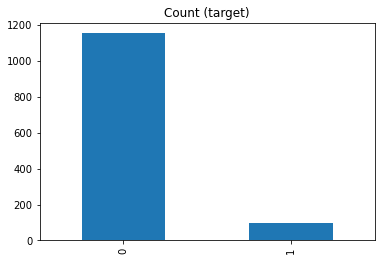

In [20]:
#Separate majority and minority classes
target_count_nm = df_non_mutual['ID'].value_counts()
myprint(target_count_nm)
df_majority_nm = df_non_mutual[df_non_mutual['ID']== 0] #JFK
df_minority_nm = df_non_mutual[df_non_mutual['ID']== 1] #RFK
target_count_nm.plot(kind='bar', title='Count (target)')

# # SMOTE Technique (OverSampling)

In [33]:
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(df_non_mutual.Sentence ,df_non_mutual.ID, test_size=0.30)

In [34]:
# X_train
X_train_tfidf_nm = vectorizer.fit_transform(X_train_nm) 

# X_test
X_test_tfidf_nm = vectorizer.transform(X_test_nm).toarray()

In [35]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_resample(X_train_tfidf_nm, y_train_nm) #original

# Now train the model without handling the imbalanced class distribution


In [39]:
model.fit(Xsm_train, ysm_train)
predictimb = model.predict(X_test_tfidf_nm)
predictimby = model.predict_proba(X_test_tfidf_nm) 
metrics(y_test_nm, predictimb, predictimby)

Accuracy: 0.8746666666666667
Precision: 0.25
Recall: 0.25806451612903225
Neg. Log-Likelihood: 0.3483068600883753


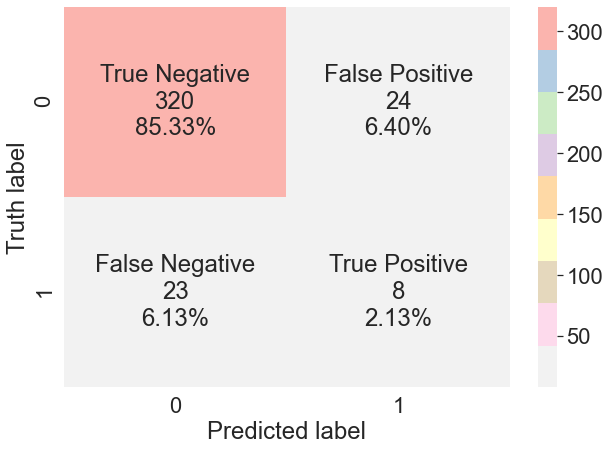

In [40]:
view_confusion_matrix(y_test_nm, predictimb)


In [41]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [42]:
oversample_model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# FIT the model

In [43]:
oversample_model.fit(Xsm_train.toarray(), ysm_train.to_numpy() , validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
5/5 - 24s - loss: 0.6080 - accuracy: 0.6708 - val_loss: 0.6961 - val_accuracy: 0.5710
Epoch 2/20
5/5 - 3s - loss: 0.3197 - accuracy: 0.9073 - val_loss: 0.3323 - val_accuracy: 0.9815
Epoch 3/20
5/5 - 3s - loss: 0.1467 - accuracy: 0.9660 - val_loss: 0.0869 - val_accuracy: 0.9907
Epoch 4/20
5/5 - 3s - loss: 0.1132 - accuracy: 0.9668 - val_loss: 0.0608 - val_accuracy: 0.9815
Epoch 5/20
5/5 - 3s - loss: 0.1049 - accuracy: 0.9637 - val_loss: 0.1195 - val_accuracy: 0.9630
Epoch 6/20
5/5 - 3s - loss: 0.0967 - accuracy: 0.9675 - val_loss: 0.0670 - val_accuracy: 0.9969
Epoch 7/20
5/5 - 3s - loss: 0.0953 - accuracy: 0.9660 - val_loss: 0.0877 - val_accuracy: 1.0000
Epoch 8/20
5/5 - 3s - loss: 0.0884 - accuracy: 0.9683 - val_loss: 0.0734 - val_accuracy: 1.0000
Epoch 9/20
5/5 - 3s - loss: 0.0876 - accuracy: 0.9675 - val_loss: 0.0883 - val_accuracy: 0.9815
Epoch 10/20
5/5 - 3s - loss: 0.0842 - accuracy: 0.9683 - val_loss: 0.0561 - val_accuracy: 1.0000
Epoch 11/20
5/5 - 3s - loss: 0.0843 - 

# Prediction

In [44]:
oversample_predictions = oversample_model.predict(X_test_tfidf_nm, batch_size=200, verbose=0)

In [45]:
oversample_predictions_y = oversample_model.predict_classes(X_test_tfidf_nm, batch_size=200, verbose=0)

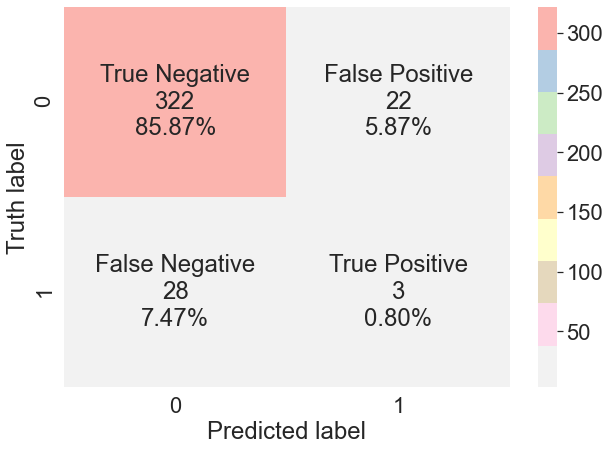

In [46]:
view_confusion_matrix(y_test_nm, oversample_predictions_y)


In [ ]:
#Rnn o lstm